In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = 33

In [2]:
# First let's read in the data.
df = pd.read_csv("./open_pv_clean.csv")
df.head()

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,16,17,24,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,level_0,index,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,cost,lbnl_tts,city,utility_clean,tech_1,model1_clean,county,annual_PV_prod,annual_insolation,rebate,sales_tax_cost,tilt1,tracking_type,azimuth1,manufacturer,inv_man_clean,reported_annual_energy_prod,new_constr,tracking,3rdparty,bipv
0,0,0,TX,2013-12-12 00:00:00,Austin Energy,uir,10.560,0.0,78702.0,residential,Advanced Solar & Electric,2.897777,30600.53,1.0,AUSTIN,Austin Energy,Poly,CHSM6610P-240,Travis,14999.831600,5.157692,15000.0,1151.693704,10.0,Fixed,180.0,Chint Solar (Zhejiang),NaN,13836.0,0.0,0.0,0.0,0
1,1,1,TX,2014-07-11 00:00:00,Austin Energy,uir,12.720,0.0,78702.0,residential,Advanced Solar & Electric,3.144654,40000.00,1.0,AUSTIN,Austin Energy,Mono,SLA265M3A,Travis,17811.574390,5.085633,15000.0,1507.165990,7.0,Fixed,180.0,NaN,NaN,16419.0,0.0,0.0,0.0,0
2,2,2,TX,2014-01-17 00:00:00,Austin Energy,uir,5.400,0.0,78702.0,residential,Advanced Solar & Electric,4.197330,22665.58,1.0,AUSTIN,Austin Energy,Mono,PLM-300M-72,Travis,7833.742822,5.262714,7735.5,854.019783,18.5,Fixed,165.0,NaN,NaN,7235.0,0.0,0.0,0.0,0
3,3,3,IN,2017-10-06 00:00:00,no_incentive_program,uir,6.785,0.0,47403.0,residential,Whole Sun Designs,2.590000,17550.00,0.0,Bloomington,no utility listed,NaN,NaN,no_county,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0
4,4,4,IN,2017-10-06 00:00:00,no_incentive_program,uir,4.720,0.0,47408.0,residential,Whole Sun Designs,2.570000,12150.00,0.0,Bloomington,no utility listed,NaN,NaN,no_county,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0


In [3]:
df.shape

(1020710, 33)

# Modeling Installation Cost
We also want to develop a model for predicting installation cost. We'll use size, installer, tracking, technology, and install type in our model. Unfortunately, the cost variable included in the OpenPV dataset is pre-incentive and pre-rebate installation cost, but we can at least get an idea of how much installation will cost.

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


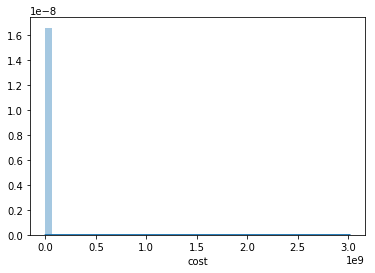

In [4]:
# Let's look at the distribution of our target variable.

# Looks very positively skewed.
plt.figure(figsize=(6,4))
sns.distplot(df.cost)

## Building Design Matrices

## Feature Selection
I chose the following features for modeling installation cost.

- size
- install type (residential, commercial, etc.)
- installer (which company)
- technology
- tracking

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import patsy

In [6]:
df_final = df[['size_kw', 'install_type', 'installer', 'tech_1', 'tracking_type', 'cost']]

In [7]:
df_final.shape

(1020710, 6)

In [8]:
df_final.head()

,size_kw,install_type,installer,tech_1,tracking_type,cost
0,10.560,residential,Advanced Solar & Electric,Poly,Fixed,30600.53
1,12.720,residential,Advanced Solar & Electric,Mono,Fixed,40000.00
2,5.400,residential,Advanced Solar & Electric,Mono,Fixed,22665.58
3,6.785,residential,Whole Sun Designs,NaN,NaN,17550.00
4,4.720,residential,Whole Sun Designs,NaN,NaN,12150.00


In [9]:
df_final.isna().sum()

size_kw               0
install_type          0
installer             0
tech_1           439791
tracking_type    494652
cost                  0
dtype: int64

In [10]:
df_final['tech_1'].value_counts()

Poly              350762
Mono              215217
crystalline         7439
Mono + a-Si         5063
CIGS                1097
CdTe                 664
a-Si                 480
a-Si + Micro-c        60
Thin Film             52
CIS                   43
multiple              42
Name: tech_1, dtype: int64

In [11]:
#df_final.dropna(inplace=True)
df_final.reset_index(drop=True, inplace=True)

In [12]:
df_final.shape

(1020710, 6)

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020710 entries, 0 to 1020709
Data columns (total 6 columns):
size_kw          1020710 non-null float64
install_type     1020710 non-null object
installer        1020710 non-null object
tech_1           580919 non-null object
tracking_type    526058 non-null object
cost             1020710 non-null float64
dtypes: float64(2), object(4)
memory usage: 46.7+ MB


## Create Dummy Variables

In [14]:
df_final = pd.get_dummies(df_final, columns = ["install_type"],prefix="install_type")

In [15]:
df_final.head()

,size_kw,installer,tech_1,tracking_type,cost,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility
0,10.560,Advanced Solar & Electric,Poly,Fixed,30600.53,0,0,0,0,0,0,0,0,1,0
1,12.720,Advanced Solar & Electric,Mono,Fixed,40000.00,0,0,0,0,0,0,0,0,1,0
2,5.400,Advanced Solar & Electric,Mono,Fixed,22665.58,0,0,0,0,0,0,0,0,1,0
3,6.785,Whole Sun Designs,NaN,NaN,17550.00,0,0,0,0,0,0,0,0,1,0
4,4.720,Whole Sun Designs,NaN,NaN,12150.00,0,0,0,0,0,0,0,0,1,0


In [16]:
# Installer
#df_final = pd.get_dummies(df_final, columns = ["installer"],prefix="installer")

In [17]:
#df_final.head()

In [18]:
# Tech
df_final = pd.get_dummies(df_final, columns = ["tech_1"],prefix="tech")

In [19]:
df_final.head()

,size_kw,installer,tracking_type,cost,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple
0,10.560,Advanced Solar & Electric,Fixed,30600.53,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,12.720,Advanced Solar & Electric,Fixed,40000.00,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,5.400,Advanced Solar & Electric,Fixed,22665.58,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,6.785,Whole Sun Designs,NaN,17550.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4.720,Whole Sun Designs,NaN,12150.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Tracking type
df_final = pd.get_dummies(df_final, columns = ["tracking_type"],prefix="tracking")

In [21]:
df_final.head()

,size_kw,installer,cost,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple,tracking_Dual-Axis,tracking_Fixed,tracking_Mixed,tracking_Single-Axis
0,10.560,Advanced Solar & Electric,30600.53,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,12.720,Advanced Solar & Electric,40000.00,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5.400,Advanced Solar & Electric,22665.58,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6.785,Whole Sun Designs,17550.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.720,Whole Sun Designs,12150.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df_final.shape

(1020710, 28)

In [24]:
y = df_final.iloc[:, 2].values

In [25]:
del(df_final['cost'])
del(df_final['installer'])

In [26]:
df_final.head()

,size_kw,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple,tracking_Dual-Axis,tracking_Fixed,tracking_Mixed,tracking_Single-Axis
0,10.560,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,12.720,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5.400,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6.785,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.720,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df_final.shape

(1020710, 26)

In [31]:
df_final.astype(int)

,size_kw,install_type_agricultural,install_type_commercial,install_type_educational,install_type_government,install_type_institutional,install_type_none,install_type_nonprofit,install_type_public,install_type_residential,install_type_utility,tech_CIGS,tech_CIS,tech_CdTe,tech_Mono,tech_Mono + a-Si,tech_Poly,tech_Thin Film,tech_a-Si,tech_a-Si + Micro-c,tech_crystalline,tech_multiple,tracking_Dual-Axis,tracking_Fixed,tracking_Mixed,tracking_Single-Axis
0,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,12,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
X = df_final.values

In [33]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75, random_state = 0)


C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
formula = "cost ~ size_kw + install_type + installer + tech_1 + tracking_type"

print('splitting into X and y design matrices')
y, X = patsy.dmatrices(formula, df, return_type='dataframe')

scaler = MinMaxScaler()

X_scaled = X.copy()


        

# not using this, just doing a built in evaluation split.
print("splitting into train and test")

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=.75)

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)

In [ ]:
# We got a pretty solid model here.
lasso_cv.score(X_test, y_test)

In [ ]:
# plotting elastic net coefficients.

coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso_cv.coef_,
    'abs_coef': np.abs(lasso_cv.coef_)
})
coefs.sort_values('abs_coef', inplace=True, ascending=False)

plt.figure(figsize=(7,10))
sns.barplot(x=coefs.coefficient.head(8), y=coefs.feature.head(8), orient='h')
plt.title("Lasso Coefficients")